In [1]:
import pandas as pd
import random
from datasets import Dataset, concatenate_datasets
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel
import torch

/u/prasanns/miniconda3/envs/rlhfenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tok = AutoTokenizer.from_pretrained("facebook/opt-125m")
mod = AutoModelForCausalLM.from_pretrained("facebook/opt-125m", device_map=3, torch_dtype=torch.bfloat16, attn_implementation="flash_attention_2")

/u/prasanns/miniconda3/envs/rlhfenv/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [3]:
mod = PeftModel.from_pretrained(mod, "../../dpo/dpoeinstein2house/checkpoint-5000/")

In [21]:
dtmp = Dataset.load_from_disk("../../data/einstein/einstein2house/")

In [5]:
stmp = Dataset.load_from_disk("../../data/einstein/einsteinsftinitial/")

In [24]:
ntmp[0]

{'question': 'This is a logic puzzle. There are 2 houses (numbered 1 on the left, 2 on the right), from the perspective of someone standing across the street from them. Each has a different person in them. They have different characteristics:\n - Each person has a unique name: eric, arnold\n - Each person has a favorite color: yellow, red\n\nRules: The person who loves yellow is Arnold. The person who loves yellow is in the first house.',
 'response_j': 'House,Name,Color\n0,arnold,yellow\n1,eric,red\n',
 'response_k': 'House,Name,Color\n0,yellow,eric\n1,arnold,red\n',
 'score_j': 6.0,
 'score_k': 3.0,
 'magnitude': 3.0,
 'sol_head': ['House', 'Name', 'Color'],
 'sol_rows': [['1', 'arnold', 'yellow'], ['2', 'eric', 'red']],
 'crules': ['The person who loves yellow is in the first house.',
  'The person who loves yellow is Arnold.'],
 'ctypes': ["<class 'clues.found_at'>", "<class 'clues.same_house'>"],
 'size': '2*2'}

In [26]:
"hi".count('\n')

0

In [22]:
dtmp[0]

{'question': 'This is a logic puzzle. There are 2 houses (numbered 1 on the left, 2 on the right), from the perspective of someone standing across the street from them. Each has a different person in them. They have different characteristics:\n - Each person has a unique name: eric, arnold\n - Each person has a favorite color: yellow, red\n\nRules: The person who loves yellow is Arnold. The person who loves yellow is in the first house.',
 'response_j': 'House,Name,Color\n0,arnold,yellow\n1,eric,red\n',
 'response_k': 'House,Name,Color\n0,yellow,eric\n1,arnold,red\n',
 'score_j': 6.0,
 'score_k': 3.0,
 'magnitude': 3.0,
 'sol_head': ['House', 'Name', 'Color'],
 'sol_rows': [['1', 'arnold', 'yellow'], ['2', 'eric', 'red']],
 'crules': ['The person who loves yellow is in the first house.',
  'The person who loves yellow is Arnold.'],
 'ctypes': ["<class 'clues.found_at'>", "<class 'clues.same_house'>"],
 'size': '2*2'}

In [15]:
einstein_reward('Answer: 0,t1,t2,t3,t4\n0,a,b,c,d\n0,e,f,g,h', [['1','a','a','a','a'], ['1','e','f','g','h']])

[['0', 'a', 'b', 'c', 'd'], ['0', 'e', 'f', 'g', 'h']]
[['1', 'a', 'a', 'a', 'a'], ['1', 'e', 'f', 'g', 'h']]
8


0.625

In [16]:
stmp = Dataset.load_from_disk("../../data/einstein/einsteinppoinps2/")

In [19]:
ntmp = Dataset.load_from_disk("../../data/einstein/einstein2house/")

In [20]:
ntmp

Dataset({
    features: ['question', 'response_j', 'response_k', 'score_j', 'score_k', 'magnitude', 'sol_head', 'sol_rows', 'crules', 'ctypes', 'size'],
    num_rows: 161044
})

In [ ]:
def fixppoinps(ex):
    question, anstmp = ex['question'].split("\nAnswer: \n")

In [18]:
stmp[0]

{'question': 'This is a logic puzzle. There are 2 houses (numbered 1 on the left, 2 on the right), from the perspective of someone standing across the street from them. Each has a different person in them. They have different characteristics:\n - Each person has a unique name: eric, arnold\n - Each person has a favorite color: yellow, red\n\nRules: The person who loves yellow is in the first house. The person who loves yellow is Arnold. \nAnswer: \nHouse,Name,Color\n0,arnold,yellow\n1,eric,red\n',
 'ind': 0,
 'sol_rows': [['1', 'arnold', 'yellow'], ['2', 'eric', 'red']],
 'size': '2*2'}

In [9]:
def einstein_reward(response, sols, log=True):

    # norm = (len(sols)*(len(sols[0])-1)*2)
    norm = len(sols)*(len(sols[0])-1)
    response = response.split("Answer:")[1].strip()
    resps = response.split("\n")
    preds = [s.split(",") for s in resps]
    mlen = max([len(l) for l in preds]+[len(sols[0])])
    for i in range(len(preds)):
        if len(preds[i])<mlen:
           preds[i] = preds[i] + ["@#$@%@#$"]*(mlen-len(preds[i]))
    preds = preds[1:]
    score = 0

    if len(sols)>len(preds): 
        sols = sols[:len(preds)]
    if len(preds)>len(sols): 
        preds = preds[:len(sols)+1]
    
    if log:
        print(preds)
        print(sols)
        print(norm)
    
    preds = np.array(preds)
    
    for i in range(len(sols)): 
        for j in range(1, len(sols[0])): 
            # NOTE simplified reward in case that's doing something weird
            if sols[i][j].strip() in preds[i][j].strip():
                score = score+1
            
            # gold = sols[i][j]
            # if gold in preds[i, :]: 
            #     if log:
            #         print(gold)
            #     score = score + 1
            # if gold in preds[:, j]: 
            #     score = score + 1
            #     if log:
            #         print(gold)
                
    score = score / norm
    return float(score)

In [30]:
def einstein_reward(response, sols, log=True):

    norm = (len(sols)*(len(sols[0])-1)*2)
    response = response.split("Answer:")[1].strip()
    resps = response.split("\n")
    preds = [s.split(",") for s in resps]
    mlen = max([len(l) for l in preds]+[len(sols[0])])
    for i in range(len(preds)):
        if len(preds[i])<mlen:
           preds[i] = preds[i] + ["@#$@%@#$"]*(mlen-len(preds[i]))
    preds = preds[1:]
    score = 0

    if len(sols)>len(preds): 
        sols = sols[:len(preds)]
    if len(preds)>len(sols): 
        preds = preds[:len(sols)+1]
    
    if log:
        print(preds)
        print(sols)
        print(norm)
    
    preds = np.array(preds)
    
    for i in range(len(sols)): 
        for j in range(1, len(sols[0])): 
            gold = sols[i][j]
            if gold in preds[i, :]: 
                if log:
                    print(gold)
                score = score + 1
            if gold in preds[:, j]: 
                score = score + 1
                if log:
                    print(gold)
                
    score = score / norm
    return float(score)

In [34]:
ind = 0
test = stmp[ind]['outputs'].split("Answer:")[0]+"Answer:\n"

inpstr = test
# print(inpstr)
inps = tok(inpstr, return_tensors="pt").to(mod.device)
out = mod.generate(**inps, do_sample=True, top_p=1, max_new_tokens=100, min_new_tokens=-1)
# print(tok.batch_decode(out, skip_special_tokens=True)[0])
out = tok.batch_decode(out, skip_special_tokens=True)[0]
print(out)
einstein_reward(out, stmp[0]['sol_rows'], True)

This is a logic puzzle. There are 2 houses (numbered 1 on the left, 2 on the right), from the perspective of someone standing across the street from them. Each has a different person in them. They have different characteristics:
 - Each person has a unique name: arnold, eric
 - They all have a different favorite flower: carnations, daffodils
 - The people are of nationalities: dane, brit
 - Everyone has a different favorite cigar: pall mall, prince

Rules: The Prince smoker is in the second house. The person who loves a carnations arrangement is directly left of Arnold. The person who loves a carnations arrangement is directly left of the Dane. 
Answer:

"Dewy's, what a joke!"

(the party)

(or, if left to be decided by a person in the third house:
- The person who loves the flower of the red carnations is in the third house)

This was my first time making this. I was not expecting how well it works. Thank you so much! :)
[['', '@#$@%@#$', '@#$@%@#$', '@#$@%@#$', '@#$@%@#$'], ['(the pa

0.0

In [123]:
data = pd.read_json("/u/prasanns/research/rlhf-length-biases/faith-and-fate/logic_grid_puzzles/advanced_data_v2/logic_grid_puzzles.train_xl.json")

In [5]:
data['solution'][0]

{'table_str': '+---------+--------+---------+\n|   House | Name   | Color   |\n+=========+========+=========+\n|       1 | arnold | yellow  |\n+---------+--------+---------+\n|       2 | eric   | red     |\n+---------+--------+---------+',
 'table_rows': [[1, 'arnold', 'yellow'], [2, 'eric', 'red']],
 'table_header': ['House', 'Name', 'Color']}

In [54]:
def makeprompt(row, use_extra=False, sftdata=False, nogold=True):
    prompt = row['puzzle_context'] + "Rules: "
    rules = row['core_rules']
    if use_extra: 
         rules = rules + row['extra_rules']
    inds = list(range(len(rules)))
    random.shuffle(inds)
    for i in inds:
        prompt = prompt + rules[i] + " "
    prompt = prompt + "\nAnswer:" 
    if sftdata: 
        sols = row['solution']['table_rows']
        potvals = []
        for r in sols: 
            for v in r: 
                if type(v) is str: 
                    potvals.append(v)
        if nogold:
            random.shuffle(potvals)
        # print(potvals)
        pind = 0
        solstr = ",".join(row['solution']['table_header']) + "\n"
        # print(len(sols))
        for i in range(len(sols)): 
            solstr = solstr+ str(i) 
            for l in range(len(sols[0])-1):
                solstr =solstr + "," + potvals[pind]
                pind += 1
            solstr = solstr + "\n"
        return prompt.strip(), solstr.strip()
    return prompt.strip()

In [47]:
def einstein_sft_data(data, per_row=2, prefset=False, addresp=True): 
    newdata = []
    for i, row in tqdm(data.iterrows(), total=len(data)):
        tmpdata = []
        for ind in range(per_row): 
            tmp = {}
            # for this one we don't need metadata, just outputs I guess? 
            tmp['outputs'] = makeprompt(row, False, addresp, ind>0)
            # print(tmp['outputs'])
            tmp['ind'] = i
            tmp['sol_rows'] = [[str(s) for s in r] for r in row['solution']['table_rows']]
            tmp['size'] = row['size']
            if prefset:
                tmp['response'] = tmp['outputs'][1]
                tmp['input'] = tmp['outputs'][0][:-10]
                tmp['sol_head'] = row['solution']['table_header']
                tmp['rules'] = row['core_rules']
                tmp['rtypes'] = row['core_rules_types']
                tmp['outputs'] = tmp['outputs'][0]+"\n"+tmp['outputs'][1]
                tmp['reward'] = einstein_reward(tmp)
            else: 
                tmp['outputs'] = tmp['outputs'][0]+"\n"+tmp['outputs'][1]
            tmpdata.append(tmp)
        if prefset: 
            odicts = {tmpdata[i]['outputs']:i for i in range(len(tmpdata))}
            vals = list(odicts.values())
            for i in range(len(vals)):
                for j in range(i, len(vals)):
                    if tmpdata[i]['reward']>tmpdata[j]['reward']: 
                        ival = "j"
                        jval = "k"
                    elif tmpdata[j]['reward']>tmpdata[i]['reward']: 
                        ival = "k"
                        jval = "j"
                    else:
                        continue
                    newdata.append({
                        'question': tmpdata[i]['input'],
                        "response_"+ival: tmpdata[i]['response'],
                        "response_"+jval: tmpdata[j]['response'],
                        'score_'+ival:  tmpdata[i]['reward'],
                        'score_'+jval:  tmpdata[j]['reward'],
                        'magnitude': abs(tmpdata[i]['reward']-tmpdata[j]['reward']),
                        'sol_head': tmpdata[i]['sol_head'],
                        'sol_rows': tmpdata[i]['sol_rows'], 
                        # track for later analysis
                        'crules': tmpdata[i]['rules'],
                        'ctypes': tmpdata[i]['rtypes'],
                        'size': row['size']
                    })   
        else: 
            newdata.extend(tmpdata)
            
    return Dataset.from_list(newdata)

In [50]:
einsteinsft1 = einstein_sft_data(data, 1, False, True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 90000/90000 [00:06<00:00, 14872.04it/s]


In [51]:
es2 = einstein_sft_data(data, 1, False, True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 90000/90000 [00:09<00:00, 9218.42it/s]


In [54]:
bigsft = concatenate_datasets([einsteinsft, es2])

In [56]:
bigsft.save_to_disk("../../data/bigsfteinstein")

In [49]:
einstein_reward(einsteinsft[0])

8

In [27]:
einsteinsft = einsteinsft.filter(lambda ex: "2*" in ex['size'], num_proc=10)

In [29]:
einsteinsft = einsteinsft.shuffle()

In [31]:
einsteinsft.select(range(25000, 30000)).save_to_disk("../../data/einsteinsftheldout")

In [28]:
einsteinsft.save_to_disk("../../data/einsteingoldsft")

In [31]:
einsteinsft = einsteinsft.rename_column("outputs", "question")

In [33]:
einsteinsft.save_to_disk("../../data/einsteinppoinps2")

(array([175767., 114964.,  64857.,  42120.,  35021.,  30944.,  14075.,
         14219.,   7840.,    604.]),
 array([ 0.5 ,  2.85,  5.2 ,  7.55,  9.9 , 12.25, 14.6 , 16.95, 19.3 ,
        21.65, 24.  ]),
 <BarContainer object of 10 artists>)

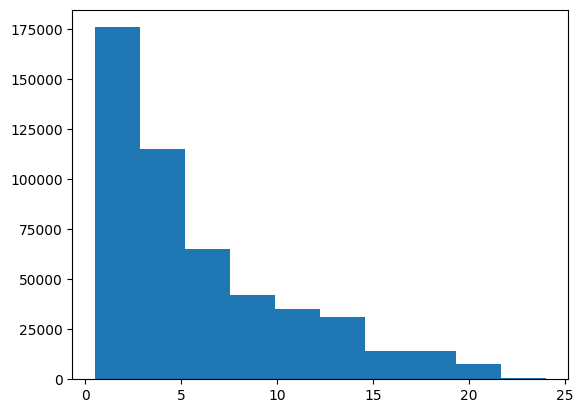

In [105]:
plt.hist(einsteinsft['magnitude'])

In [39]:
einstein_reward(einsteinsft[4], True)

['House,Name,PhoneModel,Nationality,Flower', '0,eric,samsung galaxy s21,brit,daffodils', '1,arnold,iphone 13,dane,carnations']
[['1', 'eric', 'samsung galaxy s21', 'brit', 'daffodils'], ['2', 'arnold', 'iphone 13', 'dane', 'carnations']]


16

In [107]:
# einsteinsft.save_to_disk("../../data/einsteinpreferences")
smaller = einsteinsft.filter(lambda ex: "2*" in ex['size'])

In [109]:
smaller.save_to_disk("../../data/einstein2house")

In [83]:
# given an output, and other metadata for einstein task, compute a reward 
# for each value in gold thing, +1 if that value is in the right row, +0.5 if it's in the right column
def einstein_reward(row, log=False):
    sols = row['sol_rows']
    response = row['outputs'].split("Answer: \n")[1].strip()
    resps = response.split("\n")
    if log:
        print(response)
        print(sols)
    preds = np.array([s.split(",") for s in resps])[1:, :]
    score = 0 
    for i in range(len(sols)): 
        for j in range(1, len(sols[0])): 
            gold = sols[i][j]
            if gold in preds[i, :]: 
                score = score + 1
            if gold in preds[:, j]: 
                score = score + 0.5
    return score

einstein_reward(einsteinsft[2], True)

House,Name,Color
0,red,yellow
1,eric,arnold
[['1', 'arnold', 'yellow'], ['2', 'eric', 'red']]


3.0

In [68]:
print(einsteinsft['outputs'][0])

This is a logic puzzle. There are 2 houses (numbered 1 on the left, 2 on the right), from the perspective of someone standing across the street from them. Each has a different person in them. They have different characteristics:
 - Each person has a unique name: eric, arnold
 - Each person has a favorite color: yellow, red

Rules: The person who loves yellow is Arnold. The person who loves yellow is in the first house. 
Answer: 
House,Name,Color
0,yellow,arnold
1,eric,red



In [35]:
einsteinsft = einsteinsft.shuffle(seed=0)

In [36]:
einsteinsft.save_to_disk("../../data/einsteinsft")

In [101]:
newout = makeprompt(data.loc[10001], False, True)
print(newout[0])
print(newout[1])

['bella', 'pall mall', 'arnold', 'fred', 'eric', 'prince']
2
This is a logic puzzle. There are 2 houses (numbered 1 on the left, 2 on the right), from the perspective of someone standing across the street from them. Each has a different person in them. They have different characteristics:
 - Each person has a unique name: eric, arnold
 - Each mother is accompanied by their child: bella, fred
 - Everyone has a different favorite cigar: pall mall, prince

Rules: The person's child is named Bella is in the second house. Eric is the person partial to Pall Mall. Eric is the person's child is named Fred. 
Answer: 
House,Name,Children,Cigar
0,bella,pall mall,arnold
1,fred,eric,prince



In [17]:
print(vals['puzzle_context'])
print(vals['core_rules'])
print(vals['extra_rules'])

This is a logic puzzle. There are 2 houses (numbered 1 on the left, 2 on the right), from the perspective of someone standing across the street from them. Each has a different person in them. They have different characteristics:
 - Each person has a unique name: eric, arnold
 - Each person has a favorite color: yellow, red


['The person who loves yellow is in the first house.', 'The person who loves yellow is Arnold.']
['The person who loves yellow is directly left of Eric.', 'Arnold is the person who loves yellow.', 'Eric is the person whose favorite color is red.', 'Arnold and the person whose favorite color is red are next to each other.', 'Eric is in the second house.', 'The person whose favorite color is red is Eric.', 'Arnold is in the first house.', 'Arnold is directly left of Eric.', 'The person who loves yellow and the person whose favorite color is red are next to each other.', 'The person whose favorite color is red is in the second house.']
